In [1]:
"""
Importing needed libraries
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
""" 
 Dataset path
"""
training_image_path = 'plant disease dataset/Train/Train'
validation_image_path = 'plant disease dataset/Validation/Validation'
testing_image_path = 'plant disease dataset/Test/Test'

In [3]:
""" 
Let's define the transformatiions that needed to be applied on the images. 
"""
image_transformation = transforms.Compose([
    transforms.Resize((128, 128)),  # resizing the image to 32x32
    transforms.ToTensor()  # Converting as tensor
])

In [4]:
""" 
Definig the dataset by applying transfromations on the datsset images.
"""
training_dataset = datasets.ImageFolder(
    training_image_path, transform=image_transformation)
validation_dataset = datasets.ImageFolder(
    validation_image_path, transform=image_transformation)
testing_dataset = datasets.ImageFolder(
    testing_image_path, transform=image_transformation)

In [5]:
"""  
Insights of defined dataset. 
"""

print("Size of Training Data : ", len(training_dataset))
print("Size of Validation Data : ", len(validation_dataset))
print("Size of Testing Data : ", len(testing_dataset))
print("Unique Classes : ", training_dataset.classes)

Size of Training Data :  1322
Size of Validation Data :  60
Size of Testing Data :  150
Unique Classes :  ['Healthy', 'Powdery', 'Rust']


## Base CNN model for plant disease prediction

In [6]:
""" 
Defining the dataloaders. 
    - batch_size : 32
"""
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
testing_loader = DataLoader(testing_dataset, batch_size=32)

In [7]:
""" 
Defining the basic CNN model to find how well it can predict plant disease. 
"""


class Base_CNN(nn.Module):
    def __init__(self):
        super(Base_CNN, self).__init__()
        # Definig 1 covolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increased filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)

        # Two fully connected layers
        self.fully_connected_1 = nn.Linear(64 * 32 * 32, 128)
        self.fully_connected_2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))  # Second conv + pooling
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fully_connected_1(x))
        x = self.fully_connected_2(x)
        return x

In [8]:
""" 
Initializing the Basic CNN model with, 
    - Loss : CrossEntropyLoss
    - Optimizer : SGD
    - Learning Rate : 0.01
"""
base_model = Base_CNN()
criterion_base_CNN = nn.CrossEntropyLoss()
optimizer_base_CNN = torch.optim.SGD(base_model.parameters(), lr=0.01)

In [9]:
"""
Training the Base CNN model.
"""
# Flags to store values for visualization
training_losses = []
training_accuracies = []
validation_accuracies = []

print("Starting training...")
epochs_count = 10

for epoch in range(epochs_count):
    base_model.train()
    epoch_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, labels in training_loader:
        optimizer_base_CNN.zero_grad()
        batch_outputs = base_model(inputs)
        batch_loss = criterion_base_CNN(batch_outputs, labels)
        batch_loss.backward()
        optimizer_base_CNN.step()

        epoch_loss += batch_loss.item()
        _, predicted = batch_outputs.max(1)
        training_total += labels.size(0)
        training_correct += predicted.eq(labels).sum().item()

    training_accuracy = 100. * training_correct / training_total
    training_losses.append(epoch_loss/len(training_loader))
    training_accuracies.append(training_accuracy)

    """ 
    Validation 
    """
    base_model.eval()
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = base_model(inputs)
            _, predicted = outputs.max(1)
            validation_total += labels.size(0)
            validation_correct += predicted.eq(labels).sum().item()

    validation_accuray = 100. * validation_correct / validation_total
    validation_accuracies.append(validation_accuray)

    print(f'Completed Base_CNN Epoch : {epoch+1}/{epochs_count} :')
    print(f'Training Loss: {epoch_loss/len(training_loader):.3f}')
    print(f'Training Accuracy: {training_accuracy:.2f}%')
    print(f'Validation Accuracy: {validation_accuray:.2f}%\n')

Starting training...
Completed Base_CNN Epoch : 1/10 :
Training Loss: 1.079
Training Accuracy: 43.19%
Validation Accuracy: 46.67%

Completed Base_CNN Epoch : 2/10 :
Training Loss: 0.994
Training Accuracy: 60.36%
Validation Accuracy: 41.67%

Completed Base_CNN Epoch : 3/10 :
Training Loss: 0.883
Training Accuracy: 60.67%
Validation Accuracy: 60.00%

Completed Base_CNN Epoch : 4/10 :
Training Loss: 0.784
Training Accuracy: 64.90%
Validation Accuracy: 45.00%

Completed Base_CNN Epoch : 5/10 :
Training Loss: 0.764
Training Accuracy: 66.34%
Validation Accuracy: 43.33%

Completed Base_CNN Epoch : 6/10 :
Training Loss: 0.700
Training Accuracy: 71.63%
Validation Accuracy: 55.00%

Completed Base_CNN Epoch : 7/10 :
Training Loss: 0.633
Training Accuracy: 73.90%
Validation Accuracy: 56.67%

Completed Base_CNN Epoch : 8/10 :
Training Loss: 0.599
Training Accuracy: 74.89%
Validation Accuracy: 35.00%

Completed Base_CNN Epoch : 9/10 :
Training Loss: 0.590
Training Accuracy: 76.70%
Validation Accurac

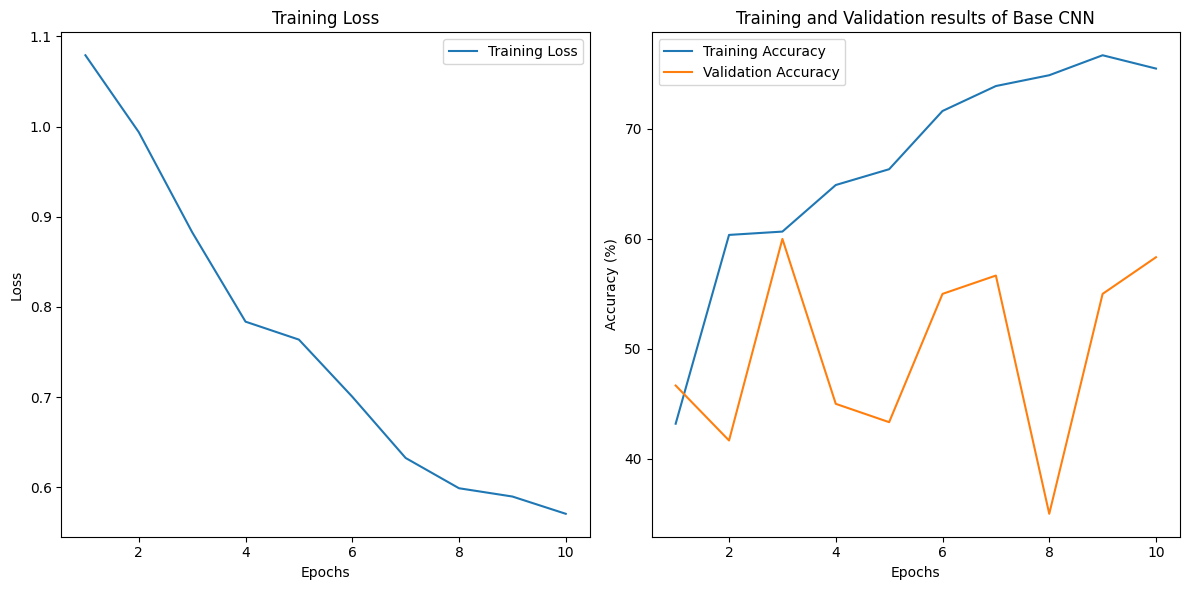

In [10]:
""" 
Visiualizing training and validation results of the Base model.
"""
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_count + 1), training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_count + 1),
         training_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs_count + 1), validation_accuracies,
         label='Validation Accuracy')
plt.title('Training and Validation results of Base CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
""" 
Evaluating the base CNN model 
"""
base_model.eval()
testing_correct = 0
testing_total = 0
with torch.no_grad():
    for inputs, labels in testing_loader:
        outputs = base_model(inputs)
        _, predicted = outputs.max(1)
        testing_total += labels.size(0)
        testing_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * testing_correct / testing_total
print(f'Test Accuracy for Base CNN: {100.*testing_correct/testing_total:.2f}%')

Test Accuracy for Base CNN: 57.33%
